# Wildfire Proximity Computation Example
This notebook contains example code that illustrate how to perform some basic geodetic computations related to the Wildfire course project. The notebook is structure as a set of examples that illustrate something about the structure of the data or illustrate a way to compute specific values. This notebook is not a tutorial on performing geodetic computations, but illustrates a number of key concepts. This notebook should provide enough information to complete the Wildfire assignment.

The complete [Wildfire dataset](https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81) can be retrieved from a US government repository. I have noticed that the repository is sometimes "down" and does not respond. It probably makes sense to get the dataset as soon as possible.

This notebook has dependencies on [Pyproj](https://pyproj4.github.io/pyproj/stable/index.html) and the [geojson](https://pypi.org/project/geojson/) module. Pyproj and geojson can be installed via pip. 

### License
This code example was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.0 - August 13, 2023

### Preliminaries
First we start with some imports and some constant definitions.

In [436]:
#    Import some standard python modules
import json
import time
#
#    The module pyproj is a standard module that can be installed using pip or your other favorite
#    installation tool. This module provides tools to convert between different geodesic coordinate systems
#    and for calculating distances between points (coordinates) in a specific geodesic system.
#
from pyproj import Transformer, Geod
import geojson
from tqdm import tqdm
import pandas as pd
import requests
import datetime
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

In [2]:
#
#    CONSTANTS
#

FILENAME = "USGS_Wildland_Fire_Combined_Dataset.json"


CITY_LOCATION = {
    'gillette': {'city': 'Gillette',
                 'latlon': [44.2911, -105.5022] }
}


## Example 1. Load the wildfire data using the geojson module

In this example we use the GeoJSON module ([documentation](https://pypi.org/project/geojson/), [GitHub repo](https://github.com/jazzband/geojson)) to load the sample file. This module works mostly the way you would expect. GeoJSON is mostly just JSON, so actually, you don't even really need to use the GeoJSON module. However, that module will do some conversion of Geo type things to something useful. However, this example, and the examples that follow, do not rely on specific Geo features from geojson.


In [3]:
#
#    Open a file, load it with the geojson loader
#
print(f"Attempting to open '{FILENAME}'")
with open(FILENAME,"r") as f:
    gj_data = geojson.load(f)


Attempting to open 'USGS_Wildland_Fire_Combined_Dataset.json'


In [4]:
#    Print the keys from the object
#
gj_keys = list(gj_data.keys())
print("The loaded JSON dictionary has the following keys:")
print(gj_keys)
print()

The loaded JSON dictionary has the following keys:
['displayFieldName', 'fieldAliases', 'geometryType', 'spatialReference', 'fields', 'features']



## Example 3. Distance computations with Pyproj

One issue in performing geodetic computation is that any (all) geographic coordinate systems are eventually translated to the surface of the earth - which is not flat. That means every computation of distance between two points is some kind of arc (not actually a straight line). Further the earth is not a true sphere, its a type of ellipsoid. That means the amount of curvature varies depending upon where you are on the surface and the direction - which changes the distance.

Lucky for us there are geographers who like to write code and have built systems to simplify the computation of distances over the earth's surface. One of those systems is called [Pyproj](https://pyproj4.github.io/pyproj/stable/index.html). It has functions that will convert coordinate points between (almost) any two of the many different geographic coordinate systems. As well, Pyproj provides ways to compute distances between two points (mostly assuming the points are already in the same coordinate system).

This example uses the Geod() object to calculate the distance between a slected starting city and all of the cities defined in our CITY_LOCATIONS dictionary (see CONSTANTS above).

The example calls the distances computed 'straight line' distances - because that is what you would have to use to find the distance between two cities using Google. If you didn't use some form of language like that Google would map roads to get you between a source and destination; that would never match our calculation.


## Example 4. Convert points between geodetic coordinate systems

One of the constraints in doing geodetic computations is that most of the time we need to have our points (the coordinates for places) in the same geographic coordinate system. There are tons and tons of coordinate systems. You can find descriptions of many of them at [EPSG.io](https://epsg.io).

Looking at the wildfire header information, you can find this in the output of Example 1, we can see fields named "geometryType" and "spatialReference". This looks like:

        "geometryType": "esriGeometryPolygon",
        "spatialReference": {
            "wkid": 102008,
            "latestWkid": 102008
        },

This indicates that the geometry of our wildfire data are generic polygons and that they are expressed in a coordinate system with the well-known ID (WKID) 102008. This coordinate system is also known as [ESRI:102008](https://epsg.io/102008)

If you look back at Example 2, you might have wondered about the line of code that says:

    geocalc = Geod(ellps='WGS84')         # Use WGS84 ellipsoid representation of the earth

That string, 'WGS84', is a representation of the earth, that also relies on a well known coordinate system that is sometimes called 'decimal degrees' (DD). That decimal degrees system has an official name (or WKID) of [EPSG:4326](https://epsg.io/4326).

For the example below, what we're going to do is take the geometry of a fire feature, extract the largest ring (i.e., the largest boundary of the fire) and convert all of the points in that ring from the ESRI:102008 coordinate system to EPSG:4326 coordinates.


In [5]:
#
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

## Example 5. Compute distance between a place and a wildfire

The basic problem is knowing how far away a fire is from some location (like a city). One issue is that fires are irregularly shaped so the actual answer to that is a bit dependent upon the exact shape and how you want to think about the notion of 'distance'. For example, should we just find the closest point on the perimiter of a fire and call that the distance? Maybe we should find the centroid of the region, identify that as a geolocation (coordinate) and then calculate the distance to that? We can come up with numerous other ways.

The first bit of code finds the point on the perimiter with the shortest distance to the city (place) and returns the distance as well as the lat,lon of the perimeter point.

The second bit of code calculates the average distance of all perimeter points to the city (place) and returns that average as the distance. This is not quite what the centroid would be, but it is probably fairly close.

These are two reasonable ways to think about possible distance to a fire. But both require computing distance to a whole set of points on the perimeter of a fire.


In [6]:
#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns a list containing the shortest distance to the perimeter and the point where that is
#
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point


In [7]:
#    Get a city from our CITY_LOCATIONS constant as our starting position
place = CITY_LOCATION["gillette"]
attributes_list = []

for feature in tqdm(gj_data['features']):
    try:
        wf_year = feature['attributes']['Fire_Year']
        if 1963 <= wf_year <= 2023:
            ring_data = feature['geometry']['rings'][0]
        
        #   Compute using the shortest distance to any point on the perimeter
            distance = shortest_distance_from_place_to_fire_perimeter(place['latlon'],ring_data)

            if distance[0] <= 1250.00:
                feature_attributes = feature['attributes']
                feature_attributes['Distance'] = distance[0]
                attributes_list.append(feature_attributes)
    except Exception as e:
        print(f"An error occurred : {e}")


# Create a DataFrame from the list of feature dictionaries
df = pd.DataFrame(attributes_list)


 81%|████████  | 109608/135061 [2:00:38<21:14, 19.98it/s]  

An error occurred : 'rings'


 82%|████████▏ | 110228/135061 [2:01:11<20:41, 20.00it/s]

An error occurred : 'rings'


 82%|████████▏ | 110640/135061 [2:01:38<35:21, 11.51it/s]

An error occurred : 'rings'


 83%|████████▎ | 111433/135061 [2:02:21<16:37, 23.68it/s]

An error occurred : 'rings'


 83%|████████▎ | 111780/135061 [2:02:37<17:56, 21.62it/s]

An error occurred : 'rings'


 83%|████████▎ | 111902/135061 [2:02:43<17:16, 22.34it/s]

An error occurred : 'rings'


 83%|████████▎ | 112414/135061 [2:03:08<15:52, 23.78it/s]

An error occurred : 'rings'
An error occurred : 'rings'


 84%|████████▍ | 113413/135061 [2:03:55<15:25, 23.39it/s]

An error occurred : 'rings'


 84%|████████▍ | 113668/135061 [2:04:08<15:06, 23.61it/s]

An error occurred : 'rings'


 84%|████████▍ | 113740/135061 [2:04:11<15:09, 23.44it/s]

An error occurred : 'rings'


 84%|████████▍ | 113771/135061 [2:04:12<15:39, 22.65it/s]

An error occurred : 'rings'


 84%|████████▍ | 113806/135061 [2:04:14<17:11, 20.60it/s]

An error occurred : 'rings'


 85%|████████▍ | 114314/135061 [2:04:42<14:44, 23.45it/s]

An error occurred : 'rings'


 85%|████████▍ | 114326/135061 [2:04:42<14:58, 23.07it/s]

An error occurred : 'rings'


 86%|████████▌ | 115632/135061 [2:05:43<14:06, 22.96it/s]

An error occurred : 'rings'


 86%|████████▌ | 115977/135061 [2:06:00<13:51, 22.94it/s]

An error occurred : 'rings'


 86%|████████▌ | 116239/135061 [2:06:12<14:28, 21.68it/s]

An error occurred : 'rings'


 87%|████████▋ | 117091/135061 [2:06:53<12:37, 23.73it/s]

An error occurred : 'rings'


 89%|████████▊ | 119586/135061 [2:08:51<13:17, 19.42it/s]

An error occurred : 'rings'


 89%|████████▊ | 119618/135061 [2:08:53<12:16, 20.97it/s]

An error occurred : 'rings'


 89%|████████▊ | 119753/135061 [2:08:59<10:41, 23.85it/s]

An error occurred : 'rings'


 89%|████████▉ | 119987/135061 [2:09:11<11:38, 21.57it/s]

An error occurred : 'rings'


 89%|████████▉ | 120214/135061 [2:09:22<11:10, 22.14it/s]

An error occurred : 'rings'


 89%|████████▉ | 120434/135061 [2:09:34<10:12, 23.89it/s]

An error occurred : 'rings'


 89%|████████▉ | 120681/135061 [2:09:45<10:44, 22.31it/s]

An error occurred : 'rings'


 89%|████████▉ | 120748/135061 [2:09:49<10:41, 22.31it/s]

An error occurred : 'rings'


 90%|████████▉ | 121013/135061 [2:10:01<09:57, 23.52it/s]

An error occurred : 'rings'


 91%|█████████ | 122266/135061 [2:11:00<09:58, 21.37it/s]

An error occurred : 'rings'


 91%|█████████ | 122536/135061 [2:11:13<09:05, 22.94it/s]

An error occurred : 'rings'


 92%|█████████▏| 123764/135061 [2:12:10<08:07, 23.16it/s]

An error occurred : 'rings'


 92%|█████████▏| 124537/135061 [2:12:51<08:34, 20.46it/s]

An error occurred : 'rings'


 93%|█████████▎| 125050/135061 [2:13:16<07:12, 23.16it/s]

An error occurred : 'rings'


 93%|█████████▎| 125750/135061 [2:13:50<06:38, 23.34it/s]

An error occurred : 'rings'


 94%|█████████▍| 127496/135061 [2:15:13<05:33, 22.71it/s]

An error occurred : 'rings'


100%|██████████| 135061/135061 [2:21:04<00:00, 15.96it/s] 


In [9]:
df.columns

Index(['OBJECTID', 'USGS_Assigned_ID', 'Assigned_Fire_Type', 'Fire_Year',
       'Fire_Polygon_Tier', 'Fire_Attribute_Tiers', 'GIS_Acres',
       'GIS_Hectares', 'Source_Datasets', 'Listed_Fire_Types',
       'Listed_Fire_Names', 'Listed_Fire_Codes', 'Listed_Fire_IDs',
       'Listed_Fire_IRWIN_IDs', 'Listed_Fire_Dates', 'Listed_Fire_Causes',
       'Listed_Fire_Cause_Class', 'Listed_Rx_Reported_Acres',
       'Listed_Map_Digitize_Methods', 'Listed_Notes', 'Processing_Notes',
       'Wildfire_Notice', 'Prescribed_Burn_Notice', 'Wildfire_and_Rx_Flag',
       'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag',
       'Exclude_From_Summary_Rasters', 'Shape_Length', 'Shape_Area',
       'Distance'],
      dtype='object')

In [10]:
df.to_csv('fire_data.csv', index=False)

In [3]:
df = pd.read_csv('output.csv')

C:\Users\mehja\AppData\Local\Temp\ipykernel_19048\1993316442.py:1: DtypeWarning: Columns (13,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('output.csv')


In [4]:
print(df.describe())

            OBJECTID  USGS_Assigned_ID     Fire_Year  Fire_Polygon_Tier  \
count   95220.000000      95220.000000  95220.000000       95220.000000   
mean    73835.225278      73835.225278   2002.319471           3.079175   
std     35822.558762      35822.558762     14.361756           2.712507   
min     14299.000000      14299.000000   1963.000000           1.000000   
25%     43003.750000      43003.750000   1992.000000           1.000000   
50%     71500.500000      71500.500000   2006.000000           1.000000   
75%    106564.250000     106564.250000   2014.000000           7.000000   
max    135061.000000     135061.000000   2020.000000           8.000000   

          GIS_Acres  GIS_Hectares  Circleness_Scale  Circle_Flag  \
count  9.522000e+04  9.522000e+04      95220.000000       7750.0   
mean   1.790256e+03  7.244909e+02          0.480785          1.0   
std    1.378054e+04  5.576786e+03          0.261342          0.0   
min    1.708042e-06  6.912200e-07          0.000051 

In [143]:
df_analysis = df.drop(columns=['OBJECTID','Fire_Polygon_Tier', 'Fire_Attribute_Tiers', 'Source_Datasets', 'Listed_Fire_Types',
       'Listed_Fire_Names', 'Listed_Fire_Codes', 'Listed_Fire_IDs',
       'Listed_Fire_IRWIN_IDs', 'Listed_Fire_Dates', 'Listed_Fire_Causes',
       'Listed_Fire_Cause_Class','Listed_Rx_Reported_Acres',
       'Listed_Map_Digitize_Methods', 'Listed_Notes', 'Processing_Notes',
       'Wildfire_Notice', 'Prescribed_Burn_Notice', 'Wildfire_and_Rx_Flag',
       'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag',
       'Exclude_From_Summary_Rasters', 'Assigned_Fire_Type'])

Air quality data

In [11]:
#########
#
#    CONSTANTS
#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "56",     # the two digit state FIPS # as a string
    "county":     "005",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}

## Example 1. Making a sign-up request

Before you can use the API you need to request a key. You will use an email address to make the request. The EPA then sends a confirmation email link and a 'key' that you use for all other requests.

You only need to sign-up once, unless you want to invalidate your current key (by getting a new key) or you lose your key.


In [8]:
#
#    This implements the sign-up request. The parameters are standardized so that this function definition matches
#    all of the others. However, the easiest way to call this is to simply call this function with your preferred
#    email address.
#
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")
    
    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

Signing Up

In [9]:
#print("Requesting SIGNUP ...")
#response = request_signup("mzameer@uw.edu")
#print(json.dumps(response,indent=4))

#Your user ID is your email address: mzameer@uw.edu
#Your key is: aquaram62

Requesting SIGNUP ...
{
    "Header": [
        {
            "status": "Success",
            "request_time": "2023-11-06T21:18:07-05:00",
            "url": "https://aqs.epa.gov/data/api/signup?email=mzameer@uw.edu"
        }
    ],
    "Data": [
        "You should receive a registration confirmation email with a link for confirming your email shortly."
    ]
}


In [14]:
USERNAME = "mzameer@uw.edu"
APIKEY = "aquaram62"

## Example 2. Making a list request
Once you have a key, the next thing is to get information about the different types of air quality monitoring (sensors) and the different places where we might find air quality stations. The monitoring system is complex and changes all the time. The EPA implementation allows an API user to find changes to monitoring sites and sensors by making requests - maybe monthly, or daily. This API approach is probably better than having the EPA publish documentation that may be out of date as soon as it hits a web page. The one problem here is that some of the responses rely on jargon or terms-of-art. That is, one needs to know a bit about the way atmospheric sciece works to understand some of the terms. ... Good thing we can use the web to search for terms we don't know!

In [12]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [15]:
#
#   The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clustors of
#   sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the
#   a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from
#   that specific sensor.
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "AIRNOW MAPS",
        "value_represented": "The parameters represented on AirNow maps (88101, 88502, and 44201)"
    },
    {
        "code": "ALL",
        "value_represented": "Select all Parameters Available"
    },
    {
        "code": "AQI POLLUTANTS",
        "value_represented": "Pollutants that have an AQI Defined"
    },
    {
        "code": "CORE_HAPS",
        "value_represented": "Urban Air Toxic Pollutants"
    },
    {
        "code": "CRITERIA",
        "value_represented": "Criteria Pollutants"
    },
    {
        "code": "CSN DART",
        "value_represented": "List of CSN speciation parameters to populate the STI DART tool"
    },
    {
        "code": "FORECAST",
        "value_represented": "Parameters routinely extracted by AirNow (STI)"
    },
    {
        "code": "HAPS",
        "value_represented": "Hazardous Air Pollutants"
    },
    {
        "code": "IMPROVE CARBON",
        "value_represented": "IMPROVE Carbon Parameters"
    }

In [16]:
#
#   Once we have a list of the classes or groups of possible sensors, we can find the sensor IDs that make up that class (group)
#   The one that looks to be associated with the Air Quality Index is "AQI POLLUTANTS"
#   We'll use that to make another list request.
#
AQI_PARAM_CLASS = "AQI POLLUTANTS"

In [17]:
#
#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))

[
    {
        "code": "42101",
        "value_represented": "Carbon monoxide"
    },
    {
        "code": "42401",
        "value_represented": "Sulfur dioxide"
    },
    {
        "code": "42602",
        "value_represented": "Nitrogen dioxide (NO2)"
    },
    {
        "code": "44201",
        "value_represented": "Ozone"
    },
    {
        "code": "81102",
        "value_represented": "PM10 Total 0-10um STP"
    },
    {
        "code": "88101",
        "value_represented": "PM2.5 - Local Conditions"
    },
    {
        "code": "88502",
        "value_represented": "Acceptable PM2.5 AQI & Speciation Mass"
    }
]


We should now have (above) a response containing a set of sensor ID numbers. The list should include the sensor numbers as well as a description or name for each sensor. 

The EPA AQS API has limits on some call parameters. Specifically, when we request data for sensors we can only specify a maximum of 5 different sensor values to return. This means we cannot get all of the Air Quality Index parameters in one request for data. We have to break it up.

What I did below was to break the request into two logical groups, the AQI sensors that sample gasses and the AQI sensors that sample particles in the air.

In [18]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"
#   
#

Air quality monitoring stations are located all over the US at different locations. We will need some sample locations to experiment with different locations to see what kinds of values come back from different sensor requests.

This list includes the [FIPS](https://www.census.gov/library/reference/code-lists/ansi.html) number for the state and county as a 5 digit string. This format, the 5 digit string, is a 'old' format that is still widely used. There are new codes that may eventually be adopted for the US government information systems. But FIPS is currently what the AQS uses, so that's what is in the list as the constant.

In [19]:
#
#   We'll use these two city locations in the examples below.
#
CITY_LOCATIONS = {
    'gillette' :       {'city'   : 'Gillette',
                       'county' : 'Campbell',
                       'state'  : 'Wyoming',
                       'fips'   : '56005',
                       'latlon' : [44.2911, -105.5022] }
}


Given our CITY_LOCATIONS constant we can now find which monitoring locations are nearby. One option is to use the county to define the area we're interest in. You can get the EPA to list their monitoring stations by county. You can also get a set of monitoring stations by using a bounding box of latitude, longitude points. For this example, we'll use the county approach. There is a bounding box example later in this notebook.

In [20]:
#
#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['gillette']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['gillette']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

if response["Header"][0]['status'] == "Success":
    print(json.dumps(response['Data'],indent=4))
else:
    print(json.dumps(response,indent=4))


[
    {
        "code": "0001",
        "value_represented": null
    },
    {
        "code": "0002",
        "value_represented": null
    },
    {
        "code": "0003",
        "value_represented": null
    },
    {
        "code": "0004",
        "value_represented": null
    },
    {
        "code": "0005",
        "value_represented": null
    },
    {
        "code": "0006",
        "value_represented": "Black Thunder BTM-7"
    },
    {
        "code": "0007",
        "value_represented": null
    },
    {
        "code": "0008",
        "value_represented": null
    },
    {
        "code": "0009",
        "value_represented": null
    },
    {
        "code": "0010",
        "value_represented": null
    },
    {
        "code": "0011",
        "value_represented": "Hilight-Reno Junction Gas Plant"
    },
    {
        "code": "0012",
        "value_represented": "Fortification Creek (WARMS site)"
    },
    {
        "code": "0013",
        "value_represented": "NARM NA-9"


The above response gives us a list of monitoring stations. Each monitoring station has a unique "code" which is a string number, and, sometimes, a description. The description seems to be something about where the monitoring station is located.


## Example 3. Making a daily summary request

The function below is designed to encapsulate requests to the EPA AQS API. When calling the function one should create/copy a parameter template, then initialize that template with values that won't change with each call. Then on each call simply pass in the parameters that need to change, like date ranges.

Another function below provides an example of extracting values and restructuring the response to make it a little more usable.

In [21]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response



In [22]:
#
#    This is a list of field names - data - that will be extracted from each record
#
EXTRACTION_FIELDS = ['sample_duration','observation_count','arithmetic_mean','aqi']

#
#    The function creates a summary record
def extract_summary_from_response(r=None, fields=EXTRACTION_FIELDS):
    ## the result will be structured around monitoring site, parameter, and then date
    result = dict()
    data = r["Data"]
    for record in data:
        # make sure the record is set up
        site = record['site_number']
        param = record['parameter_code']
        #date = record['date_local']    # this version keeps the respnse value YYYY-
        date = record['date_local'].replace('-','') # this puts it in YYYYMMDD format
        if site not in result:
            result[site] = dict()
            result[site]['local_site_name'] = record['local_site_name']
            result[site]['site_address'] = record['site_address']
            result[site]['state'] = record['state']
            result[site]['county'] = record['county']
            result[site]['city'] = record['city']
            result[site]['pollutant_type'] = dict()
        if param not in result[site]['pollutant_type']:
            result[site]['pollutant_type'][param] = dict()
            result[site]['pollutant_type'][param]['parameter_name'] = record['parameter']
            result[site]['pollutant_type'][param]['units_of_measure'] = record['units_of_measure']
            result[site]['pollutant_type'][param]['method'] = record['method']
            result[site]['pollutant_type'][param]['data'] = dict()
        if date not in result[site]['pollutant_type'][param]['data']:
            result[site]['pollutant_type'][param]['data'][date] = list()
        
        # now extract the specified fields
        extract = dict()
        for k in fields:
            if str(k) in record:
                extract[str(k)] = record[k]
            else:
                # this makes sure we always have the requested fields, even if
                # we have a missing value for a given day/month
                extract[str(k)] = None
        
        # add this extraction to the list for the day
        result[site]['pollutant_type'][param]['data'][date].append(extract)
    
    return result


In [29]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['param'] = AQI_PARAMS_GASEOUS
request_data['state'] = CITY_LOCATIONS['gillette']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['gillette']['fips'][2:]

{'email': 'mzameer@uw.edu', 'key': 'aquaram62', 'state': '56', 'county': '005', 'begin_date': '', 'end_date': '', 'minlat': 0.0, 'maxlat': 0.0, 'minlon': 0.0, 'maxlon': 0.0, 'param': '42101,42401,42602,44201', 'pclass': ''}


In [282]:
# Define the start and end years
start_year = 1974 #checked and data for the county starts from 1974 so starting from there.
end_year = 2020 #fire data ends in 2020 so not extracting AQI beyond that. 

# Create an empty list to store the data for each year
yearly_gaseous_data = []
yearly_particulate_data = []

for year in range(start_year, end_year + 1):
    # Define the start and end dates for the current year
    start_date = datetime.date(year, 1, 1)
    enddate = datetime.date(year, 12, 31)

    # Convert the start and end dates to the required format (YYYYMMDD)
    start_date = start_date.strftime("%Y%m%d")
    enddate = enddate.strftime("%Y%m%d")

    request_data['param'] = AQI_PARAMS_GASEOUS
# request daily summary data for the month of July in 2021
    gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=start_date, end_date=enddate)
    print(f"Response for the gaseous pollutants for {start_date} ...")

    if gaseous_aqi["Header"][0]['status'] == "Success":
        extract_gaseous = extract_summary_from_response(gaseous_aqi)
        yearly_gaseous_data.append(extract_gaseous)
    elif gaseous_aqi["Header"][0]['status'].startswith("No data "):
        print("No data generated")
    else:
        print(json.dumps(gaseous_aqi,indent=4))

    request_data['param'] = AQI_PARAMS_PARTICULATES

    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=start_date, end_date=enddate)
    print(f"Response for the particulate pollutants for {start_date} ...")

    if particulate_aqi["Header"][0]['status'] == "Success":
        extract_particulate = extract_summary_from_response(particulate_aqi)
        yearly_particulate_data.append(extract_particulate)
    elif particulate_aqi["Header"][0]['status'].startswith("No data "):
        print("No data generated")
    else:
        print(json.dumps(particulate_aqi,indent=4))


Response for the gaseous pollutants for 19740101 ...
Response for the particulate pollutants for 19740101 ...
No data generated
Response for the gaseous pollutants for 19750101 ...
Response for the particulate pollutants for 19750101 ...
No data generated
Response for the gaseous pollutants for 19760101 ...
Response for the particulate pollutants for 19760101 ...
No data generated
Response for the gaseous pollutants for 19770101 ...
Response for the particulate pollutants for 19770101 ...
No data generated
Response for the gaseous pollutants for 19780101 ...
Response for the particulate pollutants for 19780101 ...
No data generated
Response for the gaseous pollutants for 19790101 ...
Response for the particulate pollutants for 19790101 ...
No data generated
Response for the gaseous pollutants for 19800101 ...
Response for the particulate pollutants for 19800101 ...
No data generated
Response for the gaseous pollutants for 19810101 ...
Response for the particulate pollutants for 1981010

# Extracting Gaseous AQI

In [293]:
# Initialize the yearly_aqi dictionary as a defaultdict of lists of tuples
yearly_gaseous_aqi = defaultdict(list)

# Create a set to store unique sample_duration values
unique_sample_durations = set()

for entry in yearly_gaseous_data:
    # Iterate through the years and observations for each entry
    for site_id, site_data in entry.items():
        
        for pollutant_type, pollutant_data in site_data['pollutant_type'].items():
            
            # Extract the year from the date (e.g., '20200101' -> '2020')
            year = list(pollutant_data['data'].keys())[0][:4]
            # Initialize variables to calculate the yearly average
            total_aqi = 0
            num_entries = 0

            for date, date_data in pollutant_data['data'].items():
                for observation_data in date_data:

                    sample_duration = observation_data['sample_duration']
                    # Add it to the set
                    unique_sample_durations.add(sample_duration)
                
                    if observation_data['aqi'] is not None and observation_data['aqi'] != 0:
                        # Add the AQI value to the total
                        total_aqi += observation_data['aqi']
                        num_entries += 1

            # Append the tuple (total_aqi, num_entries) to the year in yearly_aqi
            yearly_gaseous_aqi[year].append((total_aqi, num_entries))


In [294]:
yearly_gaseous_aqi

defaultdict(list,
            {'1974': [(414, 46), (28, 2), (1032, 36)],
             '1975': [(3310, 248), (546, 16), (10729, 258)],
             '1976': [(2614, 164), (348, 4)],
             '1977': [(0, 0), (0, 0)],
             '1978': [(0, 0), (0, 0)],
             '1979': [(0, 0), (0, 0)],
             '1980': [(0, 0), (0, 0)],
             '1981': [(0, 0), (0, 0)],
             '1982': [(0, 0), (0, 0)],
             '1983': [(0, 0), (0, 0)],
             '2001': [(34900, 729), (2490, 484)],
             '2002': [(47137, 1083), (3994, 730), (14682, 646)],
             '2003': [(22748, 482),
              (3802, 288),
              (48304, 1068),
              (3118, 696),
              (11206, 648),
              (10510, 628)],
             '2004': [(42630, 1091),
              (8742, 714),
              (44216, 1086),
              (3498, 732),
              (12450, 510),
              (5940, 370),
              (10696, 512)],
             '2005': [(42963, 1095),
              (

# Extracting Particulate AQI

In [295]:
# Initialize the yearly_aqi dictionary as a defaultdict of lists of tuples
yearly_particulate_aqi = defaultdict(list)

# Create a set to store unique sample_duration values
unique_sample_durations_particulate = set()

for entry in yearly_particulate_data:
    # Iterate through the years and observations for each entry
    for site_id, site_data in entry.items():
        
        for pollutant_type, pollutant_data in site_data['pollutant_type'].items():
            
            # Extract the year from the date (e.g., '20200101' -> '2020')
            year = list(pollutant_data['data'].keys())[0][:4]
            # Initialize variables to calculate the yearly average
            total_aqi = 0
            num_entries = 0

            for date, date_data in pollutant_data['data'].items():
                for observation_data in date_data:

                    sample_duration = observation_data['sample_duration']
                    # Add it to the set
                    unique_sample_durations_particulate.add(sample_duration)
                
                    if observation_data['aqi'] is not None and observation_data['aqi'] != 0:
                        # Add the AQI value to the total
                        total_aqi += observation_data['aqi']
                        num_entries += 1

            # Append the tuple (total_aqi, num_entries) to the year in yearly_aqi
            yearly_particulate_aqi[year].append((total_aqi, num_entries))

In [296]:
yearly_particulate_aqi

defaultdict(list,
            {'1985': [(74, 5)],
             '1986': [(892, 53)],
             '1987': [(651, 26)],
             '1991': [(1438, 58),
              (114, 21),
              (1241, 60),
              (679, 55),
              (549, 34),
              (147, 16),
              (234, 15)],
             '1992': [(1587, 59),
              (1177, 58),
              (523, 42),
              (571, 54),
              (111, 13),
              (376, 48),
              (401, 27),
              (830, 55)],
             '1993': [(972, 46),
              (1016, 60),
              (679, 58),
              (454, 51),
              (404, 53),
              (377, 58),
              (438, 36),
              (751, 59),
              (350, 14),
              (576, 47),
              (154, 18),
              (837, 53)],
             '1994': [(894, 58),
              (622, 48),
              (681, 51),
              (625, 59),
              (451, 53),
              (693, 58),
              (79

In [309]:
for year in yearly_gaseous_aqi.keys():
    # Initialize variables for total AQI and data points
    total_aqi = 0
    total_data_points = 0

    # Extract AQI values and data points from gaseous AQI
    gaseous_aqi_entries = yearly_gaseous_aqi[year]
    gaseous_aqi_values = [value for value, _ in gaseous_aqi_entries]
    gaseous_data_points = [data_point for _, data_point in gaseous_aqi_entries]

    # Extract AQI values and data points from particulate AQI
    particulate_aqi_entries = yearly_particulate_aqi.get(year, [])
    particulate_aqi_values = [value for value, _ in particulate_aqi_entries]
    particulate_data_points = [data_point for _, data_point in particulate_aqi_entries]

    # Calculate the combined total AQI and data points
    total_aqi = sum(gaseous_aqi_values) + sum(particulate_aqi_values)
    total_data_points = sum(gaseous_data_points) + sum(particulate_data_points)

    # Calculate the average AQI
    average_aqi = total_aqi / total_data_points if total_data_points > 0 else 0

    year = int(year)

    if average_aqi != 0:
        df_analysis.loc[df_analysis['Fire_Year'] == year, 'AQI'] = average_aqi

df_analysis['AQI'] = df_analysis['AQI'].round(2)

In [458]:
df_analysis 

,USGS_Assigned_ID,Fire_Year,GIS_Acres,GIS_Hectares,Shape_Length,Shape_Area,Distance,AQI
0,14299,1963,40992.458271,16589.059302,73550.428118,1.658906e+08,546.046350,NaN
1,14300,1963,25757.090203,10423.524591,59920.576713,1.042352e+08,570.626026,NaN
2,14301,1963,45527.210986,18424.208617,84936.827810,1.842421e+08,535.654046,NaN
3,14302,1963,10395.010334,4206.711433,35105.903602,4.206711e+07,515.552718,NaN
4,14303,1963,9983.605738,4040.221900,26870.456126,4.040222e+07,537.692007,NaN
...,...,...,...,...,...,...,...,...
95215,135057,2020,16.412148,6.641761,2168.900740,6.641761e+04,865.458222,16.8
95216,135058,2020,7.050837,2.853373,978.666221,2.853373e+04,624.254807,16.8
95217,135059,2020,9.342668,3.780843,1958.326660,3.780843e+04,624.622591,16.8
95218,135060,2020,0.996962,0.403456,225.866452,4.034562e+03,305.733838,16.8


# Create Smoke Impact Estimates

In [533]:
# Calculate the weighted impact score for each year
weight_distance = 0.8
weight_area_burned = 0.2


df_analysis['Smoke_Estimate'] = (
    weight_distance * df_analysis['Distance'] +
    weight_area_burned * df_analysis['GIS_Acres']
)

# Group the data by 'Fire_Year' and calculate the average of the Smoke Estimate for each year
yearly_smoke_estimate = df_analysis.groupby('Fire_Year').agg({
    'Smoke_Estimate': 'mean',
    'AQI': 'mean'
}).reset_index()

# Rename the 'Smoke_Estimate' column to 'Yearly_Smoke_Estimate'
yearly_smoke_estimate.rename(columns={'Smoke_Estimate': 'Yearly_Smoke_Estimate'}, inplace=True)

# Calculate the min and max yearly Smoke Estimates
min_score = yearly_smoke_estimate['Yearly_Smoke_Estimate'].min()
max_score = yearly_smoke_estimate['Yearly_Smoke_Estimate'].max()

# Rescale the yearly Smoke Estimate to the 0-100 range
yearly_smoke_estimate['Yearly_Smoke_Estimate'] = (yearly_smoke_estimate['Yearly_Smoke_Estimate'] - min_score) / (max_score - min_score) *100


In [534]:
yearly_smoke_estimate.describe()

,Fire_Year,Yearly_Smoke_Estimate,AQI
count,58.000000,58.000000,23.000000
mean,1991.500000,37.158354,20.773478
std,16.886879,22.361836,3.499016
min,1963.000000,0.000000,13.770000
25%,1977.250000,19.792118,18.095000
50%,1991.500000,30.615409,20.590000
75%,2005.750000,51.835139,23.125000
max,2020.000000,100.000000,27.940000


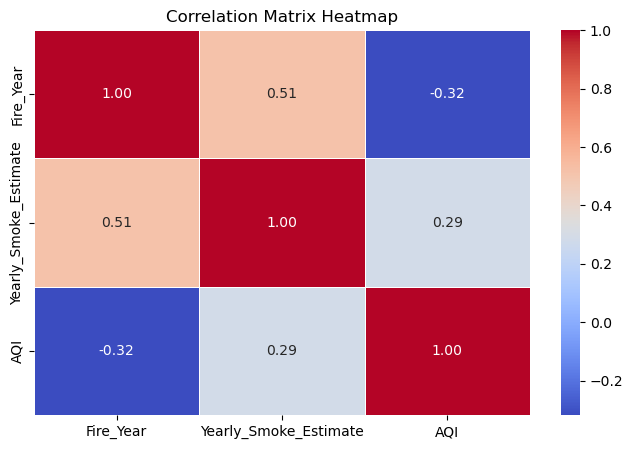

In [535]:
# Create a heatmap
plt.figure(figsize=(8, 5))  # Set the size of the heatmap
sns.heatmap(yearly_smoke_estimate.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

# Histograms

### Produce a histogram showing the number of fires occurring every 50 mile distance from your assigned city up to the max specified distance.

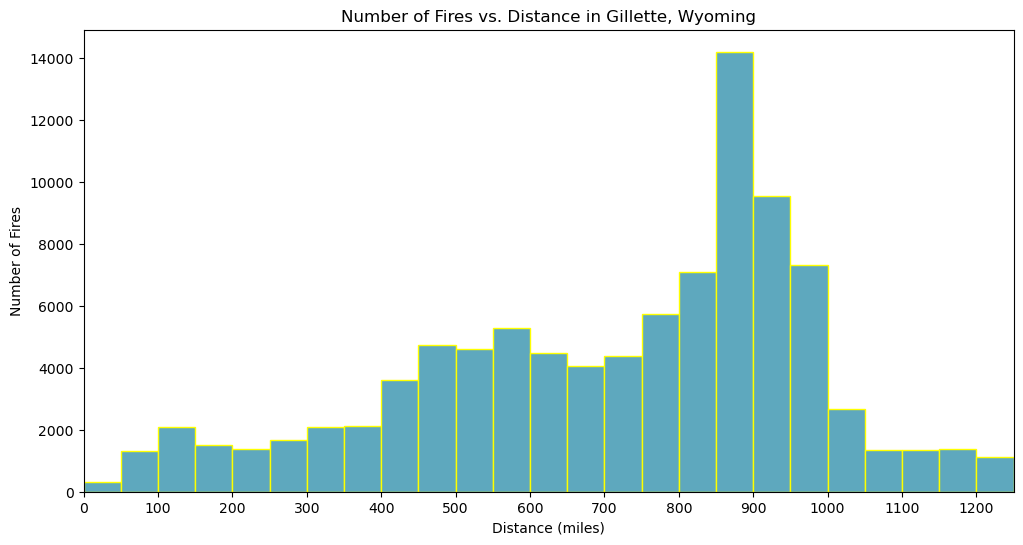

In [205]:
# Create a histogram

# Define custom colors for the bars
plt.figure(figsize=(12, 6))
ax = sns.histplot(data=df_analysis, x='Distance', bins=range(0, 1250 + 51, 50), kde=False, color = '#288BA8', edgecolor = 'yellow')
plt.xlabel('Distance (miles)')
plt.ylabel('Number of Fires')
plt.title('Number of Fires vs. Distance in Gillette, Wyoming')

# Set x-axis labels for every 200 miles
ax.set_xticks(range(0, 1250 + 1, 100))
# Ensure that 0 on the x-axis aligns with 0 on the y-axis without a gap
plt.xlim(0, 1250)

plt.show()

### Produce a time series graph of total acres burned per year for the fires occurring in the specified distance from your city.

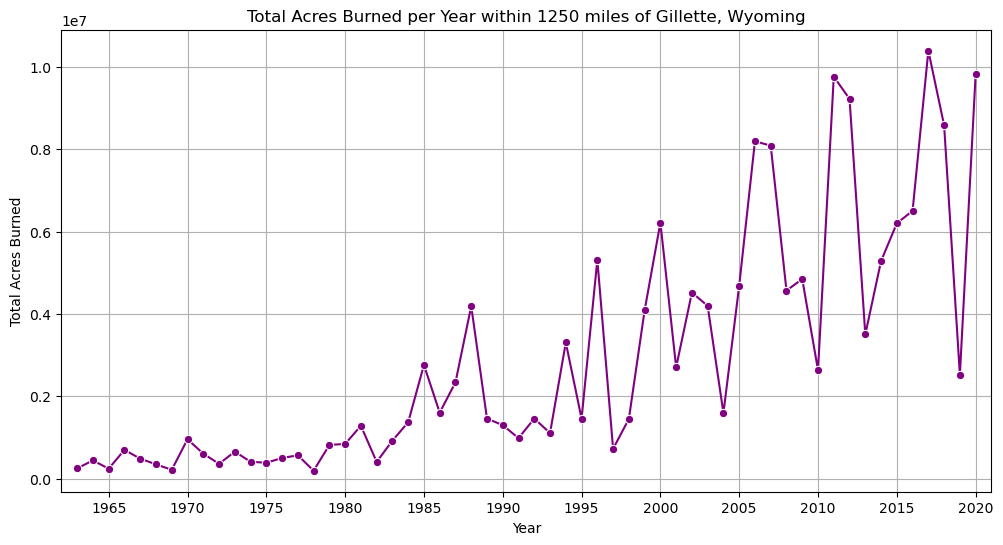

In [208]:
# Group the data by 'Fire_Year' and calculate the total acres burned per year
acres_burned_per_year = df_analysis.groupby('Fire_Year')['GIS_Acres'].sum().reset_index()

# Create a time series plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=acres_burned_per_year, x='Fire_Year', y='GIS_Acres', marker='o', color='#800080')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.title(f'Total Acres Burned per Year within 1250 miles of Gillette, Wyoming')
plt.grid(True)

# Set the X-axis labels to show every 5 years
x_ticks = np.arange(1960, 2020 + 1, 5)
plt.xticks(x_ticks)
plt.xlim(1963-1, 2020+1)
plt.show()

### Produce a time series graph containing your fire smoke estimate for your city and the AQI estimate for your city.

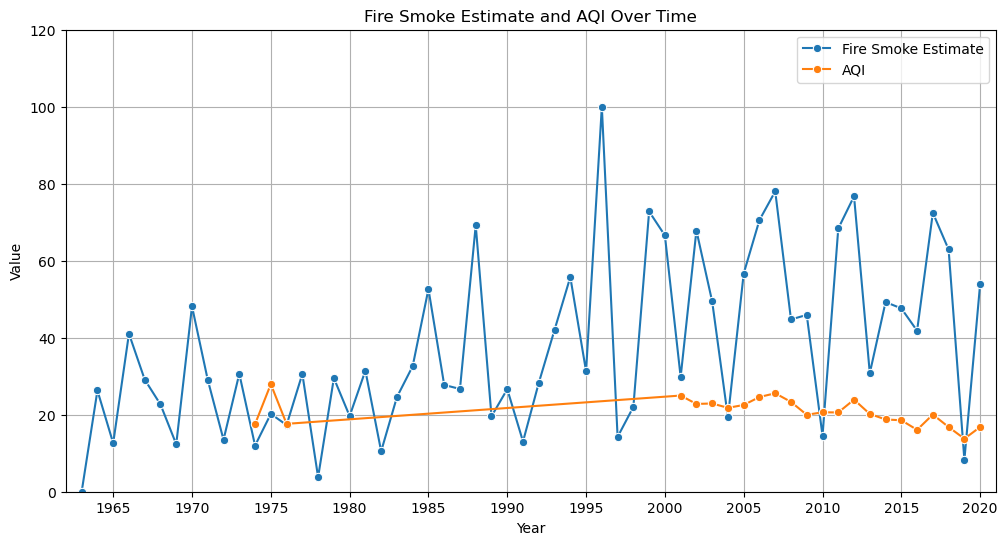

In [538]:
# Create a time series graph
plt.figure(figsize=(12, 6))  # Set the figure size

# Plot Fire Smoke Estimate
sns.lineplot(x='Fire_Year', y='Yearly_Smoke_Estimate', data=yearly_smoke_estimate, label='Fire Smoke Estimate', marker = 'o')

# Plot AQI Estimate
sns.lineplot(x='Fire_Year', y='AQI', data=yearly_smoke_estimate, label='AQI', marker = 'o')

plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Fire Smoke Estimate and AQI Over Time')
plt.legend()
plt.ylim(0,120)
x_ticks = np.arange(1960, 2020 + 1, 5)
plt.xticks(x_ticks)
plt.xlim(1963-1, 2020+1)
plt.grid(True)
plt.show()

In [540]:
# Determine the order (p, d, q) for the ARIMA model using analysis

# Fit the ARIMA model
arima_order = (20,1,0)  # Replace with your chosen values
model = ARIMA(yearly_smoke_estimate['Yearly_Smoke_Estimate'], order=arima_order)
results = model.fit()

# Make predictions (e.g., forecasting the next 12 time points)
forecast_period = 28  # Change this as needed
forecasted_values = results.forecast(steps=forecast_period)

# Create a DataFrame for the forecasted values with dates
forecast_df = pd.DataFrame(forecasted_values)
forecast_df['Year'] = range(yearly_smoke_estimate['Fire_Year'].max() + 1, yearly_smoke_estimate['Fire_Year'].max() + 1 + len(forecast_df))

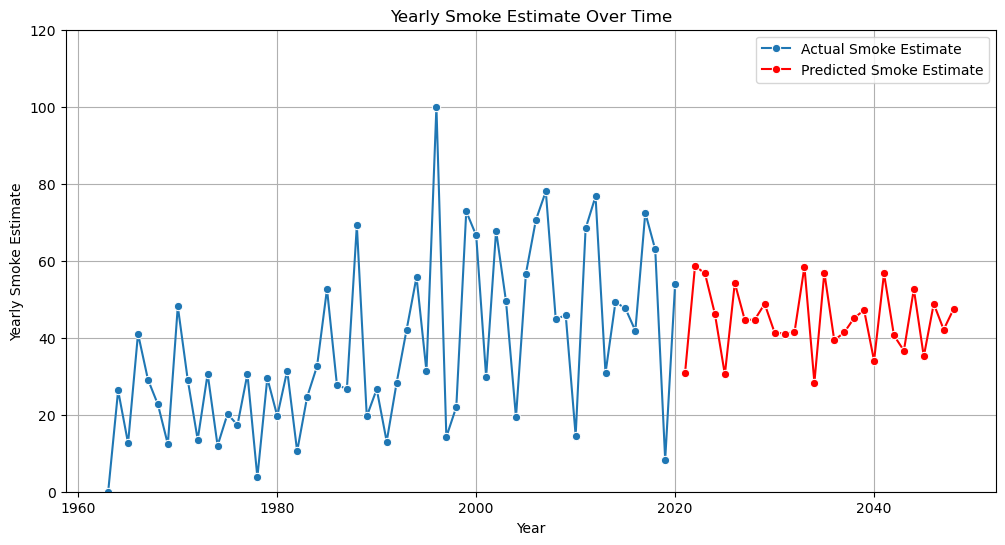

In [550]:
# Create the line plot for actual data up to 2020
plt.figure(figsize=(12, 6))
sns.lineplot(x='Fire_Year', y='Yearly_Smoke_Estimate', data=yearly_smoke_estimate, label='Actual Smoke Estimate', marker='o')

# Create the line plot for predicted data beyond 2020 with a different color
sns.lineplot(x='Year', y='predicted_mean', data=forecast_df, label='Predicted Smoke Estimate', marker='o', color='red')

plt.xlabel('Year')
plt.ylabel('Yearly Smoke Estimate')
plt.title('Yearly Smoke Estimate Over Time')
plt.legend()
plt.grid(True)
plt.ylim(0,120)
plt.show()
